# __Brough Lecture Notes: GARCH Models__

<br>

Finance 5330: Financial Econometrics <br>
Tyler J. Brough <br>
Last Updated: March 21, 2019 <br>
<br>

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from numpy import size, log, exp, pi, sum, diff, array, zeros, diag, mat, asarray, sqrt, copy
from numpy.linalg import inv

## Volatility Models

<br>

__Q:__ Why do we care about volatility? 

<br>

__1.__ Many derivative security pricing models depend explicitly upon volatility. 


_Example:_ The Black-Scholes-Merton option pricing model for a European call option:

<br>
<br>

$$
c = e^{-q T} S N(d_{1}) - e^{-r T} N(d_{2})
$$

where:

* $c =$ current call price

* $S =$ current spot price of the underlying asset

* $q =$ dividend payout rate

* $T =$ time to maturity of the contract

* $K =$ strike price of the contract

* $N(\cdot)$ is the standard normal cumulative distribution function (CDF)

and

<br>

$$
\begin{aligned}
d_{1} &= \frac{\ln{(S/K)} + (r - q + \frac{1}{2} \sigma^{2})T}{\sigma \sqrt{T}} \\
d_{2} &= d_{1} - \sigma \sqrt{T}
\end{aligned}
$$

<br>

In order to correctly price the option we often must first estimate $\sigma$!

<br>

__NB:__ The BSM model assumes that $\sigma$ is known and constant. 

<br>

___Remark:___ BSM implied volatility is (empirically) time varying

<br>

$$
\sigma_{t}^{implied}: \quad c_{t}^{obs} - c_{t}^{BSM}(\sigma_{t}^{implied}, \ldots) = 0
$$

<br>

If the BSM assumptions were correct then $\sigma_{t}^{implied} = \bar{\sigma} \mbox{(a constant)}$.

<br>

__NB:__ $\sigma_{t}^{implied}$ is an observable time series of volatility estimates based on a model for option prices.

<br>

___Remark:___ Solving the BSM model, given observed call prices, for the implied volatility requires numerical optimization techniques. The so-called Newton-Raphson method is one of the most widely used and efficient algorithms.

<br>

__2.__ Many applications in risk management and hedging require contronting the time-varying nature of volatility in financial time series data.

<br>

__3.__ Portfolio allocation in a Markowitz mean-variance framework depends explicitly on volatility (also covariance/correlation).

<br>

__4.__ Modeling the volatility of a time series can improve the efficiency in parameter estimation (e.g. feasible GLS)

<br>

## Empirical Regularities of Asset Prices

<br>

1. Thick tails: excess kurtosis decreases with aggregation


2. Volatility clustering
    - Large changes followed by large changes; small changes followed by small changes
    - FV_RR: macro aggregates are driven by shocks with heteroscedasticity
    
3. Leverage effects
    - Changes in prices often negatively correlated with changes in volatility
    
4. Non-trading Periods
    - Volatility is smaller over periods when markets are closed than when open
    
5. Forecastable events
    - Forecastable releases of information are associated with high ex ante volatility
    
6. Volatility and serial correlation
    - inverse relationship between volatility and serial correlation of stock indices
    
<br>

In [4]:
inFile = "./data/ibm-sp500.csv"
df = pd.read_csv(inFile, parse_dates=True, index_col=0)
df.head()

,PRC,sprtrn
date,,
2008-01-02,104.69,-0.014438
2008-01-03,104.90,0.000000
2008-01-04,101.13,-0.024552
2008-01-07,100.05,0.003223
2008-01-08,97.59,-0.018352


In [5]:
df.tail()

,PRC,sprtrn
date,,
2018-12-24,107.57,-0.027112
2018-12-26,111.39,0.049594
2018-12-27,113.78,0.008563
2018-12-28,113.03,-0.001242
2018-12-31,113.67,0.008492


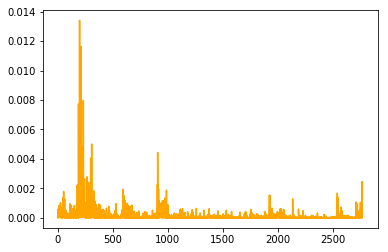

In [6]:
r2SP = df.sprtrn.values**2
plt.plot(r2SP, color="orange")

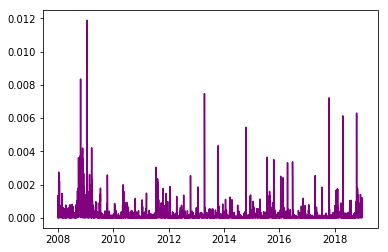

In [7]:
retIBM = df.PRC.apply(np.abs).apply(np.log).diff()
r2IBM = retIBM ** 2
plt.plot(r2IBM, color="purple")

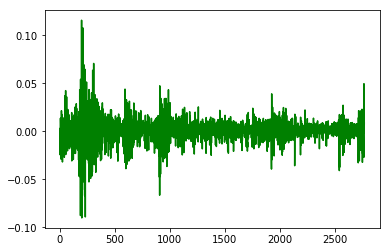

In [8]:
plt.plot(df.sprtrn.values, color="green")

## Engle's ARCH(p) Model

<br>

__ARCH:__ Autoregressive Conditional Heteroscedasticity

<br>

The simplest form is the ARCH(1) model:

$$
\begin{aligned}
y_{t}        &= x_{t}^{\prime} \beta + \epsilon_{t} \\
\epsilon_{t} &= u_{t} \sqrt{\alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2}}
\end{aligned}
$$

with $u_{t} \sim N(0, 1)$

<br>

It follows that $E(\epsilon_{t} | x_{t}, \epsilon_{t-1}) = 0$, so that $E(\epsilon_{t} | x_{t}) = 0$
and $E(y_{t} | x_{t}) = x_{t}^{\prime} \beta$. 

This is a CLRM!

<br>

__BUT__, 

$$
Var(\epsilon_{t} | \epsilon_{t-1}) = E(\epsilon_{t}^{2} | \epsilon_{t-1}) = E[u_{t}^{2}][\alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2}]
$$

<br>

So $\epsilon_{t}$ is _conditionally heteroscedastic_, not wrt to $x_{t}$ as before but with respect to $\epsilon_{t-1}$.

<br>

The unconditional variance:

$$
\begin{aligned}
Var(\epsilon_{t}) &= Var[E(\epsilon_{t} | \epsilon_{t-1})] + E[(Var(\epsilon_{t} | \epsilon_{t-1})] \\
                  &= \alpha_{0} + \alpha_{1} E[\epsilon_{t-1}^{2}] \\
                  &= \alpha_{0} + \alpha_{1} Var(\epsilon_{t-1})
\end{aligned}
$$

<br>

If the process generating the disturbances is weakly stationary, then the unconditional variance is not changing over time so

$$
\begin{aligned}
Var[\epsilon_{t}] &= Var[\epsilon_{t-1}] = \alpha_{0} + \alpha_{1} Var[\epsilon_{t-1}] \\
                  &= \frac{\alpha_{0}}{1 - \alpha_{1}}
\end{aligned}
$$

<br>
<br>

_Derivation:_

$$
\begin{aligned}
Var[\epsilon_{t-1}]                 &= \alpha_{0} + \alpha_{1} Var[\epsilon_{t-1}] \\
Var[\epsilon_{t-1}](1 - \alpha_{1}) &= \alpha_{0} \\
Var[\epsilon_{t-1}]                 &= \frac{\alpha_{0}}{1 - \alpha_{1}}
\end{aligned}
$$

<br>
<br>

For this ratio to be finite and positive, $|\alpha_{1}| < 1$.

Then, unconditionally $\epsilon_{t}$ is distributed with zero mean and variance $\sigma_{2} = \frac{\alpha_{0}}{1 - \alpha_{1}}$

<br>

Therefore, the model obeys the classical assumptions, and OLS is the most efficient linear unbiased estimator of $\beta$.

<br>

But, there is a more efficient _nonlinear_ estimator. The log-likelihood function for the model is given in Engle (1982). Conditional on starting values $y_{0}$ and $x_{0} (\epsilon_{0})$, the conditional likelihood for observations is:

$$
lnL = -\frac{T}{2} \ln(2\pi) - \frac{1}{2} \sum_{t=1}^{T} ln(\alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2}) - \frac{1}{2} \sum\limits_{t=1}^{T} \frac{\epsilon_{t-1}^{2}}{\alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2}}
$$

with $\epsilon_{t} = y_{t} - \beta^{\prime} x_{t}$

<br>

Maximization of the $lnL$ can be done with conventional methods (See Appendix E in Greene).

<br>

The most common approach is the Newton-Raphson method.

<br>

The natural extension to the ARCH(1) model is the ARCH(p) model:

<br>
<br>

$$
\sigma_{t}^{2} = \alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2} + \alpha_{2}\epsilon_{t-2}^{2} + \cdots + \alpha_{p}\epsilon_{t-p}^{2}
$$

<br>

__NB:__ This is an MA(q) process!

<br>

__Next:__ we will look at testing for ARCH effects and introduce the Genearlized ARCH or ___GARCH___ model. 

<br>

__NB:__ before we move on: Engle specified his ARCH model in terms of the linear regression model. A simple model for heteroscedasticity in return volatility could be the following (in terms of an ARCH(1) model for simplicity): 

$$
\begin{aligned}
r_{t}          &= \epsilon_{t} \sigma_{t} \quad \mbox{with} \quad \epsilon \sim N(0,1) \\
\sigma_{t}^{2} &= \alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2}
\end{aligned}
$$

<br>

Or simply as

<br>

$$
r_{t} = \epsilon_{t} \sqrt{\alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2}}
$$

<br>

With this setup, I think one can now see how to apply an IID boostrap scheme to the model by drawing from the residuals:

$$
\hat{\epsilon_{t}} = \frac{r_{t}}{\hat{\sigma_{t}}}
$$

given the estimated model parameters ($\hat{\alpha_{0}}$, $\hat{\alpha_{1}}$), and the initial condition $\epsilon_{0}$. 

<br>

One could then use this simple model to simulate a predictive density.

<br>

## Testing for ARCH Effects

<br>

Consider testing the hypotheses

<br>

$$
\begin{aligned}
H_{0}: & \quad \alpha_{1} = \alpha_{2} = \cdots = 0 \quad \mbox{(i.e. No ARCH)} \\
H_{a}: & \quad \mbox{At least one} \quad \alpha_{i} \ne 0 \quad \mbox{(ARCH)}
\end{aligned}
$$

<br>
<br>

Engle derived a simple Lagrange Multiplier (LM) test

* Step 1: Compute squared residuals $\epsilon_{t}$ from the mean equation regression

* Step 2: Estimate the auxiliary regression

$$
\hat{\epsilon}_{t}^{2} = a_{0} + a_{1} \hat{\epsilon}_{t-1}^{2} + \ldots + a_{p} \hat{\epsilon}_{t-p}^{2} + e_{t}
$$

* Step 3: Form the LM statistic

$$
LM_{ARCH} = T \cdot R_{Aux}^{2}
$$

* where $T =$ sample size from the auxiliary regression. 

* Under $H_{0}$ (No ARCH) $LM_{ARCH} \overset{a}{\sim} \chi^{2}(p)$

<br>

## Weaknesses of the ARCH Models:

* (1) The model assumes that positive and negative shocks have the same effects on volatility because it depends on the square
  of the previous shocks. This contradicts the well-known leverage effects from the stylized facts.
  
* (2) ARCH can be rather restrictive. For example, $\alpha_{1}^{2}$, of an ARCH(1) model must be in the interval $\left[0, \frac{1}{3}\right]$ if the series
  has a finite fourth moment. This gets more complicated in higher order ARCH models. It limits the ability of ARCH(p) models to allow for excess kurtosis
  from the stylized facts. 
  
* (3) The ARCH model does not provide any new insight for understanding the source of variations of time series. It merely provides a mechanical way to 
  describe the behavior of the conditional variance. It gives no indication about what causes such behavior to occur (i.e. we want a structural model)
  
* (4) ARCH models are likely to overpredict the volatility because they respond slowly to large isolated shocks to the series. 

<br>


## The GARCH Model of Bollerslev (1988)

<br>

__GARCH__ is _Generalized ARCH_

<br>

The model is as follows: 

$$
y_{t} = x_{t} \beta + \epsilon_{t}
$$

<br>

is the underlying regression conditioned on an information set at time $t\mbox{,} \quad$ $\Psi_{t}\mbox{,} \quad$ the distribution of the disturbance is assumed to be $\epsilon_{t} | \Psi_{t} \sim N(0, \sigma_{t}^{2})$.

<br>

with the conditional variance

$$
\sigma_{t}^{2} = \alpha_{0} + \delta_{1} \sigma_{t-1}^{2} + \delta_{2} \sigma_{t-2}^{2} + \cdots + \delta_{p} \sigma_{t-p}^{2} + \alpha_{1} \epsilon_{t-1}^{2} + \cdots + \alpha_{p} \epsilon_{t-p}^{2}
$$

<br>

__NB:__ the conditional variance is defined by an ARIMA(p,q) process in the innovations $\epsilon_{t}^{2}$

<br>

The resulting model is the GARCH(p,q) model

<br>

__Remark:__ It has been shown that a GARCH(p,q) with small values of $p,q$ performs better than a longer ARCH model

<br>

## Forecasting from GARCH Models

<br>

Consider the basic GARCH(1,1) model

$$
\sigma_{t}^{2} = \alpha_{0} + \alpha_{1} \epsilon_{t-1}^{2} + \delta_{1} \sigma_{t-1}^{2}
$$

<br>

from $t = 1, \ldots, T$. The best linear predictor of $\sigma_{T+1}^{2}$ using information at time $T$ is 

$$
\begin{aligned}
E(\sigma_{T+1}^{2} | \Psi_{T}) &= \alpha_{0} + \alpha_{1} E(\epsilon_{T}^{2} | \Psi_{T}) + \delta_{1} E(\sigma_{T}^{2} | \Psi_{T}) \\
                               &= \alpha_{0} + \alpha_{1} \epsilon_{T}^{2} + \delta_{1} \sigma_{T}^{2}
\end{aligned}
$$

<br>

Note that $E(\epsilon_{T+1}^{2} | \Psi_{T}) = E(\sigma_{T+1}^{2} | \Psi_{T})$ thus

$$
\begin{aligned} 
E(\sigma_{T+2}^{2} | \Psi_{T}) &= \alpha_{0} + \alpha_{1} E(\epsilon_{T+1}^{2} | \Psi_{T}) + \delta_{1} E(\sigma_{T+1}^{2} | \Psi_{T}) \\
                               &= \alpha_{0} + (\alpha_{1} + \delta_{1}) E(\sigma_{T+1}^{2} | \Psi_{T})
\end{aligned}
$$

<br>

__Note:__ as $k \rightarrow \infty$ $E(\sigma_{T+k}^{2} | \Psi_{T}) \rightarrow E(\sigma_{T}^{2}) = \frac{\alpha_{0}}{1 - \alpha_{1} - \delta_{1}}$

<br>

## Simulating GARCH Models

We can use GARCH models for Monte Carlo simulation (taking parameters of the model as given):

In [9]:
from scipy.optimize import fmin_slsqp

In [69]:
a0 = 0.0000036
a1 = 0.07
b1 = 0.92

In [70]:
sqrt(a0 / (1 - a1 - b1) * 252)

0.3011976095522687

In [84]:
def simulate_garch(parameters, numObs):
    a0 = parameters[0]
    a1 = parameters[1]
    b1 = parameters[2]
    
    u = np.random.normal(size=(numObs + 1))
    q = zeros((numObs + 1))
    r = zeros((numObs + 1))
    
    q[0] = a0 / (1.0 - a1 - b1)
    r[0] = u[0] * sqrt(q[0])
    
    for t in range(1, numObs):
        q[t] = a0 + a1 * u[t-1]**2 + b1 * q[t-1]
        r[t] = u[t] * sqrt(q[t])
        
    return (r, q)

In [85]:
numObs = 252
params = array([a0, a1, b1])
r, s = simulate_garch(params, numObs)

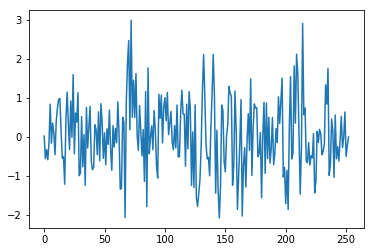

In [86]:
plt.plot(r)

In [89]:
sum(r)

12.60755659501838